<a href="https://colab.research.google.com/github/kevinkevin556/Dlchemist/blob/main/nin2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Network in Network**

# **Section 1. Set up**

In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### *Dataset and DataLoader*


How to normalize CIFAR-10: [link](https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py).

In [4]:
from torch.utils.data import Dataset, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage, Normalize

cifar10 = CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
data_means = (cifar10.data / 255.0).mean(axis=(0,1,2))
data_std = (cifar10.data / 255.0).std(axis=(0,1,2))
print("Data mean", data_means)
print("Data std", data_std)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [5]:
from torch.utils.data import Dataset, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage
from einops import rearrange


class CIFAR10Dataset(Dataset):
  def __init__(self, root="./data", mean=None, W=None,train=False, download=True, index=None):    
    cifar10 = CIFAR10(root, train, download=download)
    if index is None:
      self.data, self.targets = cifar10.data, cifar10.targets
    else:
      self.data = cifar10.data[index]
      self.targets = [cifar10.targets[i] for i in index]

    self.mean = self.data.mean(axis=0) if mean is None else mean
    self.W = self.zca_matrix((self.data-self.mean)/255.0) if W is None else W
    self.tensors = self.whiten_all_images()


  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx):
    image, label = self.tensors[idx], self.targets[idx]
    return image, label


  def zca_matrix(self, images):
    n = len(self.targets)  
    images = rearrange(images, 'N H W C -> N (H W C)')
    cov = torch.cov(Tensor(images.T))
    L, V = torch.linalg.eig(cov)
    L, V = L.real, V.real
    W = V @ torch.diag(L**(-0.5)) @ V.T
    return W


  def whiten(self, images):
    ## Whiten the image
    images = rearrange(images, 'N H W C -> N (H W C)')
    whiten_images =  Tensor(images) @ self.W 
    
    ## Tensorize the image: (dim=(c, h, w) & range=(0, 1))
    whiten_images = rearrange(whiten_images, 'N (H W C) -> N C H W', H=32, W=32)
    whiten_images = torch.clip(whiten_images, 0, 1)
    return whiten_images
  

  def whiten_all_images(self):
    n = len(self.targets)
    whiten_images = torch.empty((n, 3, 32, 32))
    batch = 100
    for i in tqdm(range(n//batch), desc="Whitening all data..."):
      images = self.data[batch*i:batch*(i+1)]
      images = (images-self.mean)/255                           # normalization
      whiten_images[batch*i:batch*(i+1)] = self.whiten(images)  # zca-whitening
    return whiten_images

[ZCA1](https://stats.stackexchange.com/questions/117427/what-is-the-difference-between-zca-whitening-and-pca-whitening)
[ZCA2](https://towardsdatascience.com/pca-whitening-vs-zca-whitening-a-numpy-2d-visual-518b32033edf#:~:text=ZCA%2Dwhitening%20is%20done%20by,possible%20from%20the%20original%20data.)

In [6]:
# Generate indices to permute the training data and conduct train-test-split
total_size = 50000
valid_size = total_size // 10
rng = np.random.default_rng(42)
indices = rng.permutation(total_size)

train_dataset = CIFAR10Dataset(train=True, index=indices[:-valid_size])
mean = train_dataset.mean
W = train_dataset.W

valid_dataset = CIFAR10Dataset(train=True, mean=mean, W=W, index=indices[-valid_size:])
test_dataset = CIFAR10Dataset(train=False, mean=mean, W=W)


print("\nData Size:")
print("* Training set   => ", len(train_dataset), "images")
print("* Validation set => ", len(valid_dataset), "images")
print("* Testing set    => ", len(test_dataset), "images")

print("\nImage Shape (C, H, W):")
print("* Training image:", train_dataset[0][0].shape)
print("* Testing image: ", test_dataset[0][0].shape)

Files already downloaded and verified


Whitening all data...: 100%|██████████| 450/450 [00:15<00:00, 29.71it/s]


Files already downloaded and verified


Whitening all data...: 100%|██████████| 50/50 [00:01<00:00, 29.82it/s]


Files already downloaded and verified


Whitening all data...: 100%|██████████| 100/100 [00:03<00:00, 30.29it/s]


Data Size:
* Training set   =>  45000 images
* Validation set =>  5000 images
* Testing set    =>  10000 images

Image Shape (C, H, W):
* Training image: torch.Size([3, 32, 32])
* Testing image:  torch.Size([3, 32, 32])


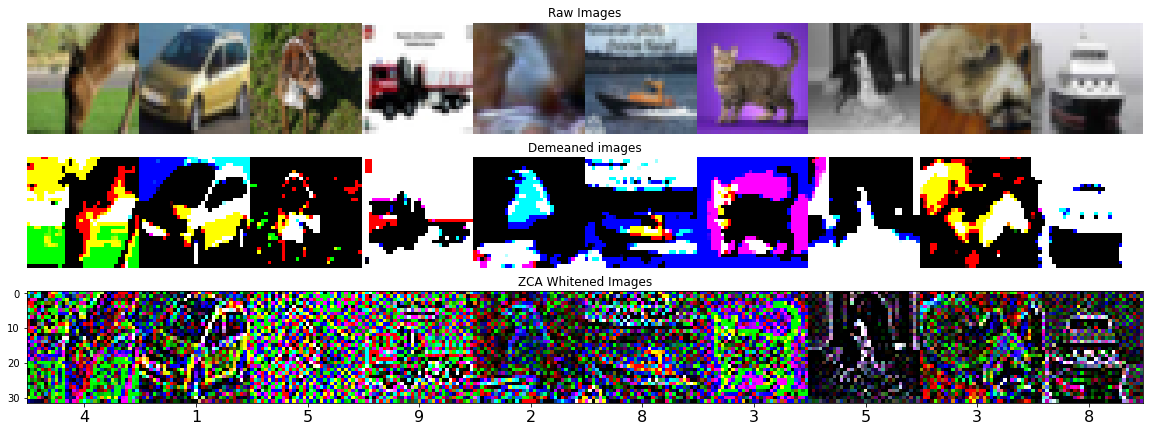


Image shape: (3, 32, 32)


In [7]:
import matplotlib.pyplot as plt

n_view = 10
pil_dstack = lambda images: ToPILImage()(torch.dstack(images))

# Sample images
raw_images = np.hstack([train_dataset.data[i] for i in range(n_view)])
demeaned_images = np.hstack([train_dataset.data[i] - mean for i in range(n_view)])
images = pil_dstack([train_dataset[i][0] for i in range(n_view)])
targets = [train_dataset[i][1] for i in range(n_view)]

fig, ax = plt.subplots(3, 1, figsize=(20, 7))
ax[0].imshow(raw_images)
ax[0].set_title("Raw Images")
ax[0].axis('off')

ax[1].imshow(demeaned_images)
ax[1].set_title("Demeaned images")
ax[1].axis('off')

ax[2].imshow(images)
ax[2].set_title("ZCA Whitened Images")
ax[2].set_xticks(ticks=np.array(range(10))*32+16)
ax[2].set_xticklabels(targets, {'fontsize':16})
plt.show()
plt.close()


image_shape = tuple(train_dataset[0][0].shape)
print("\nImage shape:", image_shape)

In [8]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

### *Network Architecture*

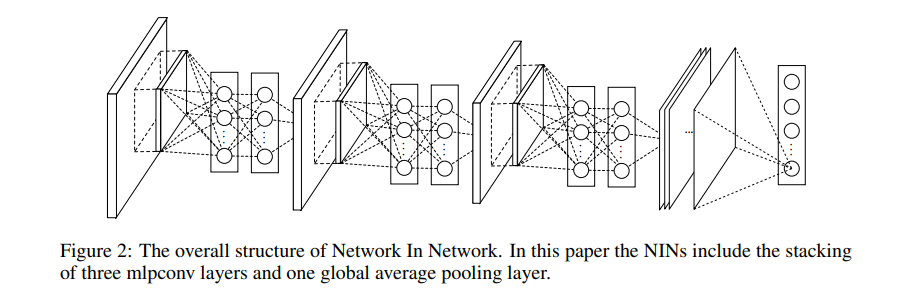

The network architecture is built based on this [prototext](https://gist.github.com/mavenlin/e56253735ef32c3c296d) from the Caffe model zoo. Note one should set `MaxPool2d(ceil_mode=True)` to get the correct dimension.


In [9]:
from torch.nn import (
    Conv2d, ReLU, MaxPool2d, AvgPool2d, Dropout, Sequential, Flatten
)


def CCCP(in_channels, out_channels):
  return Conv2d(in_channels, out_channels, kernel_size=1)

def MlpConv(in_channels, hidden_channels, out_channels, kernel_size, stride=1, padding=0):
  return nn.Sequential(
      Conv2d(in_channels, hidden_channels[0], kernel_size, stride, padding),
      ReLU(),
      CCCP(hidden_channels[0], hidden_channels[1]),
      ReLU(),
      CCCP(hidden_channels[1], out_channels),
      ReLU()
  )

class NiN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net = Sequential(
        MlpConv(3, (192, 160), 96, kernel_size=5, padding=2),
        MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        Dropout(p=0.5),

        MlpConv(96, (192, 192), 192, kernel_size=5, padding=2),
        AvgPool2d(kernel_size=3, stride=2, ceil_mode=True),
        Dropout(p=0.5),

        MlpConv(192, (192, 192), num_classes, kernel_size=3, padding=1),
        AvgPool2d(kernel_size=8, stride=1),
        Flatten()
    )

    # Remember to initialize the weights and biases.
    # Default initialization from pytorch doesn't work well.
    self.net.apply(self.init_weights)

  def forward(self, x):
    return self.net(x)

  @staticmethod
  def init_weights(m):
    if isinstance(m, Conv2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.05)
        torch.nn.init.zeros_(m.bias)

print(NiN())

NiN(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Sequential(
      (0): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (4): AvgPool2d(kernel_size=3, stride=2, padding=0)
    (5): Dropout(p=0.5, inplace=False)
    (6): Sequential(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
      (3)

In [10]:
# Check forward path
X = torch.randn(1, *image_shape)
print(f"{'Image shape:':25s} {list(X.shape)}")
for layer in NiN().net:
    X=layer(X)
    print(f"{layer.__class__.__name__+' output shape:':25s} {list(X.shape)}")

Image shape:              [1, 3, 32, 32]
Sequential output shape:  [1, 96, 32, 32]
MaxPool2d output shape:   [1, 96, 16, 16]
Dropout output shape:     [1, 96, 16, 16]
Sequential output shape:  [1, 192, 16, 16]
AvgPool2d output shape:   [1, 192, 8, 8]
Dropout output shape:     [1, 192, 8, 8]
Sequential output shape:  [1, 10, 8, 8]
AvgPool2d output shape:   [1, 10, 1, 1]
Flatten output shape:     [1, 10]


### *HyperModule*

In [49]:
import sklearn.metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class HyperModule():
    def __init__(self, model, criterion, optimizer, scheduler=None, load_path=None):
        if load_path is None:
            self.model, self.criterion, self.optimizer = model, criterion, optimizer
            self.scheduler = scheduler
            self.epoch_trained = 0
            self.train_loss = []
            self.valid_acc = []
            self.test_acc = None
        else:
            self.load(load_path)


    def train(self, train_dataloader, valid_dataloader, save_path=None, num_epochs=1):
        device = torch.device('cuda')
        self.model.to(device)
        best_acc = 0 if len(self.valid_acc)==0 else max(self.valid_acc) 
        start_epoch = self.epoch_trained

        for epoch in range(num_epochs):
            self.model.train()
            self.batch_loss, self.batch_acc = [], []
            self.epoch_trained += 1

            train_progress = tqdm(train_dataloader, position=0, leave=True)  ## Train
            for images, targets in train_progress:
                images, targets = images.to(device), targets.to(device)
                self.update_(images, targets)
                self.update_prog_(train_progress, start_epoch+num_epochs)
           
            self.update_schd_()  ## Update scheduler

            self.batch_acc = self.validate(valid_dataloader) ## Validate
            self.update_hist_()
            print(f"Train Loss: {np.mean(self.batch_loss):.3f}, Valid Acc:{np.mean(self.batch_acc):.3f}")
            
            if np.mean(self.batch_acc) > best_acc:  ## Save the best model (if any)
                best_acc = np.mean(self.batch_acc)
                self.save(save_path)

        self.batch_loss, self.batch_acc = [], []
        self.test_acc = None
        

    def validate(self, dataloader):
        device = torch.device('cuda')
        self.model.eval()
        batch_acc = []
        with torch.no_grad():
            for images, targets in dataloader:
                images, targets = images.to(device), targets.to(device)
                preds = self.model(images)
                pred_labels = torch.argmax(preds, dim=1)
                batch_acc.append((pred_labels == targets).type(torch.float32).mean().item())
        return batch_acc


    def test(self, dataloader, load_path=None, confusion_matrix=True, class_names=None):
        device = torch.device('cuda')
        np_pred_labels, np_targets = [], [] 
        if load_path is not None:
            self.load(load_path)
        self.model.to(device)
        self.model.eval()

        # Obtain predictions and ground truths
        with torch.no_grad():
            for images, targets in dataloader:
                images, targets = images.to(device), targets.to(device)
                pred_labels, targets = self.get_prediction_(images, targets)
                np_pred_labels.append(pred_labels)
                np_targets.append(targets)

        np_pred_labels = np.concatenate(np_pred_labels)
        np_targets = np.concatenate(np_targets)

        if confusion_matrix:
            conf_mat = sklearn.metrics.confusion_matrix(np_targets, np_pred_labels)
            conf_df = self.generate_confusion_df_(conf_mat, class_names)
            self.plot_confusion_matrix_(conf_df)
            self.print_class_acc_(conf_df)
        
        ## print total accuracy
        self.test_acc = np.mean(np_targets == np_pred_labels)
        print("\nTotal Acc:", np.mean(np_targets == np_pred_labels))

                
    def load(self, path):
        device = torch.device('cuda')
        state_dict = torch.load(path)
        
        self.model.load_state_dict(state_dict["model"])
        self.model.to(device)
        
        self.optimizer.load_state_dict(state_dict["optimizer"])
        self.scheduler.load_state_dict(state_dict["scheduler"])
        self.test_acc = state_dict["test_acc"]
        self.epoch_trained = state_dict["epoch_trained"]
        self.train_loss = state_dict["train_loss"]
        self.valid_acc = state_dict["valid_acc"]
        print("State dict sucessfully loaded.")


    def save(self, path):
        state_dict = {}
        state_dict["model"] = self.model.state_dict()
        state_dict["optimizer"] = self.optimizer.state_dict()
        state_dict["scheduler"] = self.scheduler.state_dict()
        state_dict["epoch_trained"] = self.epoch_trained
        state_dict["train_loss"] = self.train_loss
        state_dict["valid_acc"] = self.valid_acc
        state_dict["test_acc"] = self.test_acc
        torch.save(state_dict, path)
        print("State dict saved.")
    

    def get_state_dict(self):
        state_dict = {}
        state_dict["model"] = self.model.state_dict()
        state_dict["optimizer"] = self.optimizer.state_dict()
        state_dict["scheduler"] = self.scheduler.state_dict()
        state_dict["epoch_trained"] = self.epoch_trained
        state_dict["train_loss"] = self.train_loss
        state_dict["valid_acc"] = self.valid_acc
        state_dict["test_acc"] = self.test_acc
        return state_dict

    #--------------------------------------------------------------------------#

    ### Auxilary functions in test()
     
    def get_prediction_(self, images, targets):
        preds = self.model(images)
        pred_labels = torch.argmax(preds, dim=1)
        pred_labels = pred_labels.view(-1).detach().cpu().numpy()
        targets = targets.view(-1).detach().cpu().numpy()
        return pred_labels, targets

    def generate_confusion_df_(self, conf_mat, class_names):
        if class_names is not None:
            conf_df = pd.DataFrame(conf_mat, class_names, class_names)
        else:
            conf_df = pd.DataFrame(conf_mat)
        return conf_df
        
    def plot_confusion_matrix_(self, conf_df):
        plt.figure(figsize = (12,8))
        sns.heatmap(conf_df, annot=True, fmt="d", cmap='Blues')
        plt.xlabel("prediction")
        plt.ylabel("label (ground truth)")
        plt.show()

    def print_class_acc_(self, conf_df):
        for i in range(len(conf_df)):
            total = np.sum(conf_df.iloc[i, :])
            correct = conf_df.iloc[i, i]
            print(f"Acc of {conf_df.columns[i]}: {correct/total:.4f}")

    
    ### Auxilary functions in train()
    
    def update_(self, images, targets):
        preds = self.model(images)
        loss = self.criterion(preds, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.batch_loss.append(loss.detach().item())

    def update_prog_(self, progress, num_epochs):
        loss = self.batch_loss[-1]
        epoch = self.epoch_trained
        progress.set_description(f'Epoch [{epoch}/{num_epochs}]')
        progress.set_postfix({'loss': loss})

    def update_schd_(self):
        if self.scheduler is not None:
            self.scheduler.step()

    def update_hist_(self):
        # print("Train loss updated:", np.mean(self.batch_loss))
        self.train_loss.append(np.mean(self.batch_loss))
        # print("Valid acc updated:", np.mean(self.batch_acc))
        self.valid_acc.append(np.mean(self.batch_acc))

# **Section 2. Start Training**

### *Optimization Configuration and First Training Stage*

In [50]:
BASE_LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
STEP_SIZE = 1e5
GAMMA = 0.1
NUM_EPOCHS = 230
PATH = "/content/gdrive/MyDrive/Colab Checkpoints/state_dict.ckpt"

In [ ]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

nin = NiN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nin.parameters(), BASE_LR, MOMENTUM, 0, WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, STEP_SIZE, GAMMA)

hm = HyperModule(
    model = nin,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler
)

hm.train(train_dataloader, valid_dataloader, PATH, NUM_EPOCHS)

Epoch [1/230]: 100%|██████████| 352/352 [00:23<00:00, 15.05it/s, loss=2.3]


Train Loss: 2.302, Valid Acc:0.104
State dict saved.


Epoch [2/230]: 100%|██████████| 352/352 [00:21<00:00, 16.56it/s, loss=2.3]


Train Loss: 2.302, Valid Acc:0.111
State dict saved.


Epoch [3/230]: 100%|██████████| 352/352 [00:21<00:00, 16.37it/s, loss=2.3]


Train Loss: 2.299, Valid Acc:0.129
State dict saved.


Epoch [4/230]: 100%|██████████| 352/352 [00:21<00:00, 16.29it/s, loss=2.3]


Train Loss: 2.292, Valid Acc:0.127


Epoch [5/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=2.33]


Train Loss: 2.279, Valid Acc:0.175
State dict saved.


Epoch [6/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=2.27]


Train Loss: 2.259, Valid Acc:0.189
State dict saved.


Epoch [7/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=2.24]


Train Loss: 2.245, Valid Acc:0.172


Epoch [8/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=2.25]


Train Loss: 2.233, Valid Acc:0.194
State dict saved.


Epoch [9/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=2.23]


Train Loss: 2.219, Valid Acc:0.216
State dict saved.


Epoch [10/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=2.21]


Train Loss: 2.214, Valid Acc:0.213


Epoch [11/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=2.19]


Train Loss: 2.206, Valid Acc:0.210


Epoch [12/230]: 100%|██████████| 352/352 [00:21<00:00, 16.41it/s, loss=2.21]


Train Loss: 2.199, Valid Acc:0.221
State dict saved.


Epoch [13/230]: 100%|██████████| 352/352 [00:21<00:00, 16.32it/s, loss=2.09]


Train Loss: 2.187, Valid Acc:0.230
State dict saved.


Epoch [14/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=2.08]


Train Loss: 2.167, Valid Acc:0.257
State dict saved.


Epoch [15/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=2.14]


Train Loss: 2.129, Valid Acc:0.226


Epoch [16/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=2.09]


Train Loss: 2.108, Valid Acc:0.269
State dict saved.


Epoch [17/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=2.04]


Train Loss: 2.090, Valid Acc:0.264


Epoch [18/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=1.96]


Train Loss: 2.049, Valid Acc:0.303
State dict saved.


Epoch [19/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=1.98]


Train Loss: 2.026, Valid Acc:0.334
State dict saved.


Epoch [20/230]: 100%|██████████| 352/352 [00:21<00:00, 16.45it/s, loss=2.08]


Train Loss: 2.005, Valid Acc:0.343
State dict saved.


Epoch [21/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=1.81]


Train Loss: 1.988, Valid Acc:0.336


Epoch [22/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=1.85]


Train Loss: 1.929, Valid Acc:0.364
State dict saved.


Epoch [23/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=1.88]


Train Loss: 1.888, Valid Acc:0.319


Epoch [24/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=1.56]


Train Loss: 1.777, Valid Acc:0.377
State dict saved.


Epoch [25/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=1.56]


Train Loss: 1.633, Valid Acc:0.419
State dict saved.


Epoch [26/230]: 100%|██████████| 352/352 [00:21<00:00, 16.46it/s, loss=1.45]


Train Loss: 1.544, Valid Acc:0.379


Epoch [27/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=1.37]


Train Loss: 1.504, Valid Acc:0.437
State dict saved.


Epoch [28/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=1.46]


Train Loss: 1.459, Valid Acc:0.485
State dict saved.


Epoch [29/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=1.19]


Train Loss: 1.401, Valid Acc:0.518
State dict saved.


Epoch [30/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=1.42]


Train Loss: 1.386, Valid Acc:0.521
State dict saved.


Epoch [31/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=1.21]


Train Loss: 1.337, Valid Acc:0.516


Epoch [32/230]: 100%|██████████| 352/352 [00:21<00:00, 16.39it/s, loss=1.41]


Train Loss: 1.330, Valid Acc:0.478


Epoch [33/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=1.28]


Train Loss: 1.299, Valid Acc:0.559
State dict saved.


Epoch [34/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=1.29]


Train Loss: 1.271, Valid Acc:0.518


Epoch [35/230]: 100%|██████████| 352/352 [00:21<00:00, 16.45it/s, loss=1.2]


Train Loss: 1.239, Valid Acc:0.555


Epoch [36/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=1.21]


Train Loss: 1.209, Valid Acc:0.579
State dict saved.


Epoch [37/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=1.11]


Train Loss: 1.202, Valid Acc:0.568


Epoch [38/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=1.1]


Train Loss: 1.177, Valid Acc:0.576


Epoch [39/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=1.29]


Train Loss: 1.154, Valid Acc:0.571


Epoch [40/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=1.07]


Train Loss: 1.145, Valid Acc:0.549


Epoch [41/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=1.03]


Train Loss: 1.117, Valid Acc:0.562


Epoch [42/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=1.19]


Train Loss: 1.090, Valid Acc:0.612
State dict saved.


Epoch [43/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=1.01]


Train Loss: 1.075, Valid Acc:0.611


Epoch [44/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=1.11]


Train Loss: 1.051, Valid Acc:0.590


Epoch [45/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=1.14]


Train Loss: 1.040, Valid Acc:0.569


Epoch [46/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=0.995]


Train Loss: 1.020, Valid Acc:0.615
State dict saved.


Epoch [47/230]: 100%|██████████| 352/352 [00:21<00:00, 16.46it/s, loss=1.14]


Train Loss: 1.014, Valid Acc:0.630
State dict saved.


Epoch [48/230]: 100%|██████████| 352/352 [00:21<00:00, 16.46it/s, loss=0.99]


Train Loss: 0.991, Valid Acc:0.613


Epoch [49/230]: 100%|██████████| 352/352 [00:21<00:00, 16.41it/s, loss=1]


Train Loss: 0.979, Valid Acc:0.627


Epoch [50/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=0.848]


Train Loss: 0.960, Valid Acc:0.644
State dict saved.


Epoch [51/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=0.822]


Train Loss: 0.941, Valid Acc:0.624


Epoch [52/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=0.906]


Train Loss: 0.928, Valid Acc:0.654
State dict saved.


Epoch [53/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=1.14]


Train Loss: 0.908, Valid Acc:0.623


Epoch [54/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=1.02]


Train Loss: 0.897, Valid Acc:0.661
State dict saved.


Epoch [55/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=0.968]


Train Loss: 0.882, Valid Acc:0.654


Epoch [56/230]: 100%|██████████| 352/352 [00:21<00:00, 16.45it/s, loss=1.1]


Train Loss: 0.876, Valid Acc:0.606


Epoch [57/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=0.968]


Train Loss: 0.860, Valid Acc:0.635


Epoch [58/230]: 100%|██████████| 352/352 [00:21<00:00, 16.41it/s, loss=0.88]


Train Loss: 0.850, Valid Acc:0.673
State dict saved.


Epoch [59/230]: 100%|██████████| 352/352 [00:21<00:00, 16.41it/s, loss=0.873]


Train Loss: 0.822, Valid Acc:0.673


Epoch [60/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=1.05]


Train Loss: 0.823, Valid Acc:0.662


Epoch [61/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=1.02]


Train Loss: 0.813, Valid Acc:0.661


Epoch [62/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=0.999]


Train Loss: 0.801, Valid Acc:0.679
State dict saved.


Epoch [63/230]: 100%|██████████| 352/352 [00:21<00:00, 16.45it/s, loss=0.81]


Train Loss: 0.779, Valid Acc:0.669


Epoch [64/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=0.798]


Train Loss: 0.775, Valid Acc:0.669


Epoch [65/230]: 100%|██████████| 352/352 [00:21<00:00, 16.45it/s, loss=0.632]


Train Loss: 0.756, Valid Acc:0.677


Epoch [66/230]: 100%|██████████| 352/352 [00:21<00:00, 16.46it/s, loss=0.621]


Train Loss: 0.744, Valid Acc:0.693
State dict saved.


Epoch [67/230]: 100%|██████████| 352/352 [00:21<00:00, 16.40it/s, loss=0.807]


Train Loss: 0.743, Valid Acc:0.695
State dict saved.


Epoch [68/230]: 100%|██████████| 352/352 [00:21<00:00, 16.41it/s, loss=0.55]


Train Loss: 0.722, Valid Acc:0.694


Epoch [69/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=0.804]


Train Loss: 0.722, Valid Acc:0.690


Epoch [70/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=0.705]


Train Loss: 0.701, Valid Acc:0.711
State dict saved.


Epoch [71/230]: 100%|██████████| 352/352 [00:21<00:00, 16.45it/s, loss=0.655]


Train Loss: 0.686, Valid Acc:0.677


Epoch [72/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=0.659]


Train Loss: 0.685, Valid Acc:0.688


Epoch [73/230]: 100%|██████████| 352/352 [00:21<00:00, 16.41it/s, loss=0.661]


Train Loss: 0.674, Valid Acc:0.703


Epoch [74/230]: 100%|██████████| 352/352 [00:21<00:00, 16.46it/s, loss=0.69]


Train Loss: 0.657, Valid Acc:0.709


Epoch [75/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=0.827]


Train Loss: 0.648, Valid Acc:0.696


Epoch [76/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=0.613]


Train Loss: 0.645, Valid Acc:0.683


Epoch [77/230]: 100%|██████████| 352/352 [00:21<00:00, 16.44it/s, loss=0.549]


Train Loss: 0.638, Valid Acc:0.703


Epoch [78/230]: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s, loss=0.747]


Train Loss: 0.626, Valid Acc:0.709


Epoch [79/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=0.667]


Train Loss: 0.614, Valid Acc:0.692


Epoch [80/230]: 100%|██████████| 352/352 [00:21<00:00, 16.45it/s, loss=0.804]


Train Loss: 0.604, Valid Acc:0.707


Epoch [81/230]: 100%|██████████| 352/352 [00:21<00:00, 16.45it/s, loss=0.481]


Train Loss: 0.595, Valid Acc:0.696


Epoch [82/230]: 100%|██████████| 352/352 [00:21<00:00, 16.42it/s, loss=0.564]


Train Loss: 0.592, Valid Acc:0.698


Epoch [83/230]:  52%|█████▏    | 184/352 [00:11<00:10, 16.48it/s, loss=0.455]

In [52]:
hm.train(train_dataloader, valid_dataloader, PATH, NUM_EPOCHS-83)

Epoch [84/230]: 100%|██████████| 352/352 [00:21<00:00, 16.74it/s, loss=0.494]


Train Loss: 0.569, Valid Acc:0.724
State dict saved.


Epoch [85/230]: 100%|██████████| 352/352 [00:21<00:00, 16.57it/s, loss=0.52]


Train Loss: 0.557, Valid Acc:0.726
State dict saved.


Epoch [86/230]: 100%|██████████| 352/352 [00:20<00:00, 16.84it/s, loss=0.564]


Train Loss: 0.561, Valid Acc:0.716


Epoch [87/230]: 100%|██████████| 352/352 [00:20<00:00, 16.96it/s, loss=0.542]


Train Loss: 0.552, Valid Acc:0.693


Epoch [88/230]: 100%|██████████| 352/352 [00:20<00:00, 16.92it/s, loss=0.625]


Train Loss: 0.540, Valid Acc:0.699


Epoch [89/230]: 100%|██████████| 352/352 [00:20<00:00, 16.83it/s, loss=0.655]


Train Loss: 0.532, Valid Acc:0.729
State dict saved.


Epoch [90/230]: 100%|██████████| 352/352 [00:20<00:00, 16.86it/s, loss=0.807]


Train Loss: 0.523, Valid Acc:0.727


Epoch [91/230]: 100%|██████████| 352/352 [00:20<00:00, 16.82it/s, loss=0.517]


Train Loss: 0.516, Valid Acc:0.717


Epoch [92/230]: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s, loss=0.508]


Train Loss: 0.511, Valid Acc:0.736
State dict saved.


Epoch [93/230]: 100%|██████████| 352/352 [00:20<00:00, 16.93it/s, loss=0.555]


Train Loss: 0.498, Valid Acc:0.723


Epoch [94/230]: 100%|██████████| 352/352 [00:20<00:00, 16.97it/s, loss=0.481]


Train Loss: 0.503, Valid Acc:0.704


Epoch [95/230]: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s, loss=0.419]


Train Loss: 0.490, Valid Acc:0.715


Epoch [96/230]: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s, loss=0.503]


Train Loss: 0.475, Valid Acc:0.718


Epoch [97/230]: 100%|██████████| 352/352 [00:20<00:00, 16.79it/s, loss=0.32]


Train Loss: 0.476, Valid Acc:0.719


Epoch [98/230]: 100%|██████████| 352/352 [00:20<00:00, 16.86it/s, loss=0.485]


Train Loss: 0.473, Valid Acc:0.725


Epoch [99/230]: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s, loss=0.359]


Train Loss: 0.464, Valid Acc:0.721


Epoch [100/230]: 100%|██████████| 352/352 [00:20<00:00, 16.86it/s, loss=0.49]


Train Loss: 0.455, Valid Acc:0.733


Epoch [101/230]: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s, loss=0.436]


Train Loss: 0.442, Valid Acc:0.719


Epoch [102/230]: 100%|██████████| 352/352 [00:20<00:00, 16.90it/s, loss=0.47]


Train Loss: 0.444, Valid Acc:0.730


Epoch [103/230]: 100%|██████████| 352/352 [00:20<00:00, 16.92it/s, loss=0.456]


Train Loss: 0.440, Valid Acc:0.727


Epoch [104/230]: 100%|██████████| 352/352 [00:20<00:00, 16.93it/s, loss=0.518]


Train Loss: 0.425, Valid Acc:0.730


Epoch [105/230]: 100%|██████████| 352/352 [00:20<00:00, 16.94it/s, loss=0.612]


Train Loss: 0.422, Valid Acc:0.723


Epoch [106/230]: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s, loss=0.511]


Train Loss: 0.428, Valid Acc:0.727


Epoch [107/230]: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s, loss=0.279]


Train Loss: 0.420, Valid Acc:0.705


Epoch [108/230]: 100%|██████████| 352/352 [00:20<00:00, 16.97it/s, loss=0.368]


Train Loss: 0.404, Valid Acc:0.729


Epoch [109/230]: 100%|██████████| 352/352 [00:20<00:00, 16.95it/s, loss=0.381]


Train Loss: 0.408, Valid Acc:0.730


Epoch [110/230]: 100%|██████████| 352/352 [00:20<00:00, 16.91it/s, loss=0.36]


Train Loss: 0.389, Valid Acc:0.727


Epoch [111/230]: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s, loss=0.486]


Train Loss: 0.392, Valid Acc:0.734


Epoch [112/230]: 100%|██████████| 352/352 [00:20<00:00, 16.93it/s, loss=0.357]


Train Loss: 0.389, Valid Acc:0.729


Epoch [113/230]: 100%|██████████| 352/352 [00:20<00:00, 16.92it/s, loss=0.455]


Train Loss: 0.377, Valid Acc:0.725


Epoch [114/230]: 100%|██████████| 352/352 [00:20<00:00, 16.94it/s, loss=0.398]


Train Loss: 0.378, Valid Acc:0.729


Epoch [115/230]: 100%|██████████| 352/352 [00:20<00:00, 16.91it/s, loss=0.423]


Train Loss: 0.366, Valid Acc:0.737
State dict saved.


Epoch [116/230]: 100%|██████████| 352/352 [00:20<00:00, 17.01it/s, loss=0.48]


Train Loss: 0.372, Valid Acc:0.725


Epoch [117/230]: 100%|██████████| 352/352 [00:20<00:00, 16.95it/s, loss=0.267]


Train Loss: 0.361, Valid Acc:0.721


Epoch [118/230]: 100%|██████████| 352/352 [00:20<00:00, 16.96it/s, loss=0.452]


Train Loss: 0.355, Valid Acc:0.735


Epoch [119/230]: 100%|██████████| 352/352 [00:20<00:00, 16.92it/s, loss=0.316]


Train Loss: 0.348, Valid Acc:0.718


Epoch [120/230]: 100%|██████████| 352/352 [00:20<00:00, 16.92it/s, loss=0.448]


Train Loss: 0.354, Valid Acc:0.734


Epoch [121/230]: 100%|██████████| 352/352 [00:20<00:00, 16.93it/s, loss=0.53]


Train Loss: 0.335, Valid Acc:0.720


Epoch [122/230]: 100%|██████████| 352/352 [00:20<00:00, 16.97it/s, loss=0.3]


Train Loss: 0.336, Valid Acc:0.730


Epoch [123/230]: 100%|██████████| 352/352 [00:20<00:00, 16.94it/s, loss=0.183]


Train Loss: 0.331, Valid Acc:0.718


Epoch [124/230]: 100%|██████████| 352/352 [00:20<00:00, 16.82it/s, loss=0.407]


Train Loss: 0.323, Valid Acc:0.734


Epoch [125/230]: 100%|██████████| 352/352 [00:20<00:00, 16.98it/s, loss=0.322]


Train Loss: 0.316, Valid Acc:0.738
State dict saved.


Epoch [126/230]: 100%|██████████| 352/352 [00:20<00:00, 16.98it/s, loss=0.358]


Train Loss: 0.313, Valid Acc:0.722


Epoch [127/230]: 100%|██████████| 352/352 [00:20<00:00, 17.00it/s, loss=0.296]


Train Loss: 0.313, Valid Acc:0.720


Epoch [128/230]: 100%|██████████| 352/352 [00:20<00:00, 16.96it/s, loss=0.311]


Train Loss: 0.310, Valid Acc:0.740
State dict saved.


Epoch [129/230]: 100%|██████████| 352/352 [00:20<00:00, 16.81it/s, loss=0.29]


Train Loss: 0.307, Valid Acc:0.718


Epoch [130/230]: 100%|██████████| 352/352 [00:21<00:00, 16.73it/s, loss=0.318]


Train Loss: 0.303, Valid Acc:0.713


Epoch [131/230]: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s, loss=0.278]


Train Loss: 0.293, Valid Acc:0.727


Epoch [132/230]: 100%|██████████| 352/352 [00:21<00:00, 16.76it/s, loss=0.448]


Train Loss: 0.291, Valid Acc:0.720


Epoch [133/230]: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s, loss=0.237]


Train Loss: 0.291, Valid Acc:0.743
State dict saved.


Epoch [134/230]: 100%|██████████| 352/352 [00:20<00:00, 16.78it/s, loss=0.301]


Train Loss: 0.285, Valid Acc:0.743


Epoch [135/230]: 100%|██████████| 352/352 [00:21<00:00, 16.69it/s, loss=0.305]


Train Loss: 0.277, Valid Acc:0.732


Epoch [136/230]: 100%|██████████| 352/352 [00:21<00:00, 16.76it/s, loss=0.299]


Train Loss: 0.281, Valid Acc:0.736


Epoch [137/230]: 100%|██████████| 352/352 [00:20<00:00, 16.79it/s, loss=0.315]


Train Loss: 0.283, Valid Acc:0.727


Epoch [138/230]: 100%|██████████| 352/352 [00:21<00:00, 16.69it/s, loss=0.107]


Train Loss: 0.268, Valid Acc:0.741


Epoch [139/230]: 100%|██████████| 352/352 [00:21<00:00, 16.75it/s, loss=0.362]


Train Loss: 0.267, Valid Acc:0.729


Epoch [140/230]: 100%|██████████| 352/352 [00:20<00:00, 16.76it/s, loss=0.126]


Train Loss: 0.263, Valid Acc:0.716


Epoch [141/230]: 100%|██████████| 352/352 [00:21<00:00, 16.65it/s, loss=0.185]


Train Loss: 0.260, Valid Acc:0.730


Epoch [142/230]: 100%|██████████| 352/352 [00:21<00:00, 16.69it/s, loss=0.114]


Train Loss: 0.245, Valid Acc:0.726


Epoch [143/230]: 100%|██████████| 352/352 [00:21<00:00, 16.73it/s, loss=0.196]


Train Loss: 0.252, Valid Acc:0.735


Epoch [144/230]: 100%|██████████| 352/352 [00:21<00:00, 16.69it/s, loss=0.155]


Train Loss: 0.243, Valid Acc:0.739


Epoch [145/230]: 100%|██████████| 352/352 [00:21<00:00, 16.75it/s, loss=0.19]


Train Loss: 0.243, Valid Acc:0.740


Epoch [146/230]: 100%|██████████| 352/352 [00:21<00:00, 16.74it/s, loss=0.348]


Train Loss: 0.245, Valid Acc:0.733


Epoch [147/230]: 100%|██████████| 352/352 [00:21<00:00, 16.73it/s, loss=0.322]


Train Loss: 0.246, Valid Acc:0.740


Epoch [148/230]: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s, loss=0.249]


Train Loss: 0.245, Valid Acc:0.743


Epoch [149/230]: 100%|██████████| 352/352 [00:21<00:00, 16.73it/s, loss=0.388]


Train Loss: 0.229, Valid Acc:0.722


Epoch [150/230]: 100%|██████████| 352/352 [00:21<00:00, 16.71it/s, loss=0.303]


Train Loss: 0.234, Valid Acc:0.731


Epoch [151/230]: 100%|██████████| 352/352 [00:21<00:00, 16.71it/s, loss=0.177]


Train Loss: 0.234, Valid Acc:0.723


Epoch [152/230]: 100%|██████████| 352/352 [00:21<00:00, 16.71it/s, loss=0.226]


Train Loss: 0.225, Valid Acc:0.738


Epoch [153/230]: 100%|██████████| 352/352 [00:21<00:00, 16.69it/s, loss=0.17]


Train Loss: 0.220, Valid Acc:0.728


Epoch [154/230]: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s, loss=0.179]


Train Loss: 0.220, Valid Acc:0.738


Epoch [155/230]: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s, loss=0.159]


Train Loss: 0.209, Valid Acc:0.732


Epoch [156/230]: 100%|██████████| 352/352 [00:21<00:00, 16.66it/s, loss=0.33]


Train Loss: 0.210, Valid Acc:0.727


Epoch [157/230]: 100%|██████████| 352/352 [00:21<00:00, 16.71it/s, loss=0.25]


Train Loss: 0.214, Valid Acc:0.731


Epoch [158/230]: 100%|██████████| 352/352 [00:21<00:00, 16.74it/s, loss=0.212]


Train Loss: 0.211, Valid Acc:0.739


Epoch [159/230]: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s, loss=0.291]


Train Loss: 0.203, Valid Acc:0.729


Epoch [160/230]: 100%|██████████| 352/352 [00:21<00:00, 16.71it/s, loss=0.168]


Train Loss: 0.205, Valid Acc:0.730


Epoch [161/230]: 100%|██████████| 352/352 [00:21<00:00, 16.69it/s, loss=0.312]


Train Loss: 0.208, Valid Acc:0.737


Epoch [162/230]: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s, loss=0.316]


Train Loss: 0.197, Valid Acc:0.741


Epoch [163/230]: 100%|██████████| 352/352 [00:21<00:00, 16.62it/s, loss=0.362]


Train Loss: 0.197, Valid Acc:0.733


Epoch [164/230]: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s, loss=0.211]


Train Loss: 0.208, Valid Acc:0.728


Epoch [165/230]: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s, loss=0.21]


Train Loss: 0.185, Valid Acc:0.736


Epoch [166/230]: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s, loss=0.304]


Train Loss: 0.189, Valid Acc:0.741


Epoch [167/230]: 100%|██████████| 352/352 [00:21<00:00, 16.73it/s, loss=0.169]


Train Loss: 0.175, Valid Acc:0.737


Epoch [168/230]: 100%|██████████| 352/352 [00:20<00:00, 16.78it/s, loss=0.247]


Train Loss: 0.185, Valid Acc:0.735


Epoch [169/230]: 100%|██████████| 352/352 [00:21<00:00, 16.74it/s, loss=0.235]


Train Loss: 0.178, Valid Acc:0.736


Epoch [170/230]: 100%|██████████| 352/352 [00:21<00:00, 16.61it/s, loss=0.0911]


Train Loss: 0.186, Valid Acc:0.749
State dict saved.


Epoch [171/230]: 100%|██████████| 352/352 [00:21<00:00, 16.74it/s, loss=0.164]


Train Loss: 0.180, Valid Acc:0.746


Epoch [172/230]: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s, loss=0.246]


Train Loss: 0.180, Valid Acc:0.742


Epoch [173/230]: 100%|██████████| 352/352 [00:21<00:00, 16.74it/s, loss=0.0783]


Train Loss: 0.167, Valid Acc:0.724


Epoch [174/230]: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s, loss=0.275]


Train Loss: 0.184, Valid Acc:0.731


Epoch [175/230]: 100%|██████████| 352/352 [00:21<00:00, 16.74it/s, loss=0.0901]


Train Loss: 0.178, Valid Acc:0.733


Epoch [176/230]: 100%|██████████| 352/352 [00:21<00:00, 16.70it/s, loss=0.214]


Train Loss: 0.174, Valid Acc:0.741


Epoch [177/230]: 100%|██████████| 352/352 [00:20<00:00, 16.77it/s, loss=0.195]


Train Loss: 0.173, Valid Acc:0.735


Epoch [178/230]: 100%|██████████| 352/352 [00:21<00:00, 16.70it/s, loss=0.18]


Train Loss: 0.161, Valid Acc:0.729


Epoch [179/230]: 100%|██████████| 352/352 [00:21<00:00, 16.73it/s, loss=0.208]


Train Loss: 0.166, Valid Acc:0.739


Epoch [180/230]: 100%|██████████| 352/352 [00:21<00:00, 16.71it/s, loss=0.159]


Train Loss: 0.170, Valid Acc:0.730


Epoch [181/230]: 100%|██████████| 352/352 [00:21<00:00, 16.74it/s, loss=0.0815]


Train Loss: 0.165, Valid Acc:0.743


Epoch [182/230]: 100%|██████████| 352/352 [00:21<00:00, 16.71it/s, loss=0.0886]


Train Loss: 0.166, Valid Acc:0.729


Epoch [183/230]: 100%|██████████| 352/352 [00:21<00:00, 16.75it/s, loss=0.135]


Train Loss: 0.152, Valid Acc:0.744


Epoch [184/230]: 100%|██████████| 352/352 [00:21<00:00, 16.76it/s, loss=0.206]


Train Loss: 0.156, Valid Acc:0.743


Epoch [185/230]: 100%|██████████| 352/352 [00:20<00:00, 16.77it/s, loss=0.322]


Train Loss: 0.150, Valid Acc:0.730


Epoch [186/230]: 100%|██████████| 352/352 [00:20<00:00, 16.81it/s, loss=0.182]


Train Loss: 0.160, Valid Acc:0.752
State dict saved.


Epoch [187/230]: 100%|██████████| 352/352 [00:20<00:00, 16.78it/s, loss=0.0991]


Train Loss: 0.146, Valid Acc:0.743


Epoch [188/230]: 100%|██████████| 352/352 [00:21<00:00, 16.60it/s, loss=0.188]


Train Loss: 0.152, Valid Acc:0.743


Epoch [189/230]: 100%|██████████| 352/352 [00:21<00:00, 16.65it/s, loss=0.331]


Train Loss: 0.149, Valid Acc:0.748


Epoch [190/230]: 100%|██████████| 352/352 [00:21<00:00, 16.62it/s, loss=0.124]


Train Loss: 0.147, Valid Acc:0.739


Epoch [191/230]: 100%|██████████| 352/352 [00:21<00:00, 16.65it/s, loss=0.161]


Train Loss: 0.146, Valid Acc:0.735


Epoch [192/230]: 100%|██████████| 352/352 [00:21<00:00, 16.61it/s, loss=0.204]


Train Loss: 0.148, Valid Acc:0.725


Epoch [193/230]: 100%|██████████| 352/352 [00:21<00:00, 16.67it/s, loss=0.211]


Train Loss: 0.141, Valid Acc:0.734


Epoch [194/230]: 100%|██████████| 352/352 [00:21<00:00, 16.59it/s, loss=0.0874]


Train Loss: 0.146, Valid Acc:0.745


Epoch [195/230]: 100%|██████████| 352/352 [00:21<00:00, 16.58it/s, loss=0.229]


Train Loss: 0.146, Valid Acc:0.740


Epoch [196/230]: 100%|██████████| 352/352 [00:21<00:00, 16.60it/s, loss=0.102]


Train Loss: 0.136, Valid Acc:0.735


Epoch [197/230]: 100%|██████████| 352/352 [00:21<00:00, 16.61it/s, loss=0.254]


Train Loss: 0.146, Valid Acc:0.733


Epoch [198/230]: 100%|██████████| 352/352 [00:21<00:00, 16.56it/s, loss=0.0973]


Train Loss: 0.133, Valid Acc:0.736


Epoch [199/230]: 100%|██████████| 352/352 [00:21<00:00, 16.64it/s, loss=0.352]


Train Loss: 0.138, Valid Acc:0.739


Epoch [200/230]: 100%|██████████| 352/352 [00:21<00:00, 16.53it/s, loss=0.137]


Train Loss: 0.136, Valid Acc:0.741


Epoch [201/230]: 100%|██████████| 352/352 [00:21<00:00, 16.63it/s, loss=0.0872]


Train Loss: 0.140, Valid Acc:0.736


Epoch [202/230]: 100%|██████████| 352/352 [00:21<00:00, 16.62it/s, loss=0.104]


Train Loss: 0.142, Valid Acc:0.740


Epoch [203/230]: 100%|██████████| 352/352 [00:21<00:00, 16.64it/s, loss=0.193]


Train Loss: 0.135, Valid Acc:0.729


Epoch [204/230]: 100%|██████████| 352/352 [00:21<00:00, 16.57it/s, loss=0.118]


Train Loss: 0.126, Valid Acc:0.744


Epoch [205/230]: 100%|██████████| 352/352 [00:21<00:00, 16.56it/s, loss=0.228]


Train Loss: 0.130, Valid Acc:0.727


Epoch [206/230]: 100%|██████████| 352/352 [00:21<00:00, 16.60it/s, loss=0.245]


Train Loss: 0.129, Valid Acc:0.738


Epoch [207/230]: 100%|██████████| 352/352 [00:21<00:00, 16.65it/s, loss=0.154]


Train Loss: 0.125, Valid Acc:0.742


Epoch [208/230]: 100%|██████████| 352/352 [00:21<00:00, 16.70it/s, loss=0.119]


Train Loss: 0.126, Valid Acc:0.741


Epoch [209/230]: 100%|██████████| 352/352 [00:21<00:00, 16.70it/s, loss=0.103]


Train Loss: 0.122, Valid Acc:0.735


Epoch [210/230]: 100%|██████████| 352/352 [00:21<00:00, 16.70it/s, loss=0.106]


Train Loss: 0.124, Valid Acc:0.739


Epoch [211/230]: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s, loss=0.0544]


Train Loss: 0.130, Valid Acc:0.745


Epoch [212/230]: 100%|██████████| 352/352 [00:21<00:00, 16.60it/s, loss=0.134]


Train Loss: 0.114, Valid Acc:0.748


Epoch [213/230]: 100%|██████████| 352/352 [00:21<00:00, 16.67it/s, loss=0.173]


Train Loss: 0.117, Valid Acc:0.732


Epoch [214/230]: 100%|██████████| 352/352 [00:21<00:00, 16.58it/s, loss=0.117]


Train Loss: 0.122, Valid Acc:0.734


Epoch [215/230]: 100%|██████████| 352/352 [00:21<00:00, 16.62it/s, loss=0.118]


Train Loss: 0.118, Valid Acc:0.748


Epoch [216/230]: 100%|██████████| 352/352 [00:21<00:00, 16.62it/s, loss=0.13]


Train Loss: 0.125, Valid Acc:0.726


Epoch [217/230]: 100%|██████████| 352/352 [00:21<00:00, 16.63it/s, loss=0.237]


Train Loss: 0.116, Valid Acc:0.744


Epoch [218/230]: 100%|██████████| 352/352 [00:21<00:00, 16.63it/s, loss=0.136]


Train Loss: 0.119, Valid Acc:0.713


Epoch [219/230]: 100%|██████████| 352/352 [00:21<00:00, 16.63it/s, loss=0.16]


Train Loss: 0.122, Valid Acc:0.732


Epoch [220/230]: 100%|██████████| 352/352 [00:21<00:00, 16.60it/s, loss=0.124]


Train Loss: 0.115, Valid Acc:0.737


Epoch [221/230]: 100%|██████████| 352/352 [00:21<00:00, 16.61it/s, loss=0.177]


Train Loss: 0.123, Valid Acc:0.737


Epoch [222/230]: 100%|██████████| 352/352 [00:21<00:00, 16.59it/s, loss=0.192]


Train Loss: 0.123, Valid Acc:0.737


Epoch [223/230]: 100%|██████████| 352/352 [00:21<00:00, 16.73it/s, loss=0.159]


Train Loss: 0.115, Valid Acc:0.742


Epoch [224/230]: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s, loss=0.0622]


Train Loss: 0.117, Valid Acc:0.741


Epoch [225/230]: 100%|██████████| 352/352 [00:21<00:00, 16.69it/s, loss=0.105]


Train Loss: 0.112, Valid Acc:0.746


Epoch [226/230]: 100%|██████████| 352/352 [00:21<00:00, 16.67it/s, loss=0.068]


Train Loss: 0.104, Valid Acc:0.734


Epoch [227/230]: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s, loss=0.129]


Train Loss: 0.102, Valid Acc:0.742


Epoch [228/230]: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s, loss=0.185]


Train Loss: 0.114, Valid Acc:0.746


Epoch [229/230]: 100%|██████████| 352/352 [00:21<00:00, 16.65it/s, loss=0.143]


Train Loss: 0.109, Valid Acc:0.752


Epoch [230/230]: 100%|██████████| 352/352 [00:21<00:00, 16.64it/s, loss=0.155]


Train Loss: 0.106, Valid Acc:0.737


State dict sucessfully loaded.


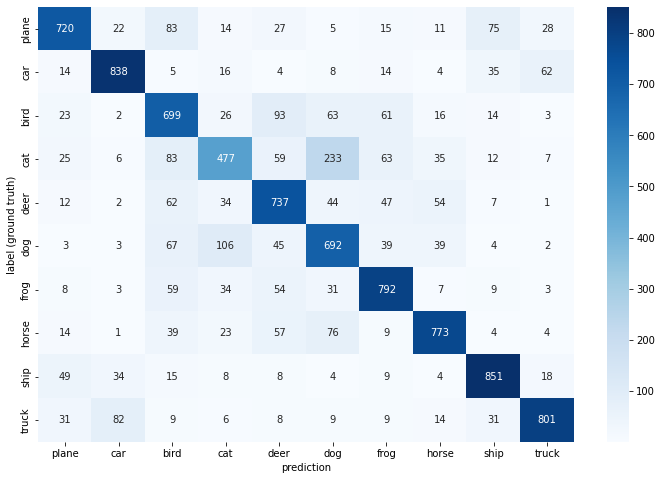

Acc of plane: 0.7200
Acc of car: 0.8380
Acc of bird: 0.6990
Acc of cat: 0.4770
Acc of deer: 0.7370
Acc of dog: 0.6920
Acc of frog: 0.7920
Acc of horse: 0.7730
Acc of ship: 0.8510
Acc of truck: 0.8010

Total Acc: 0.738


In [53]:
hm.test(test_dataloader, load_path=PATH, class_names=class_names)

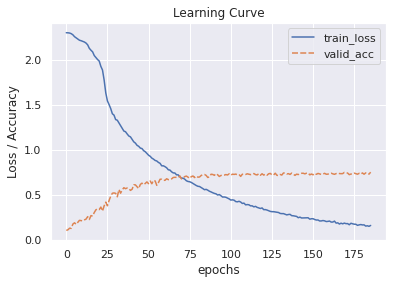

In [62]:
state_dict = hm.get_state_dict()
train_info = {key:state_dict[key] for key in ["train_loss", "valid_acc"]}

sns.set_theme()
fig, ax = plt.subplots(1, 1)
sns.lineplot(ax=ax, data=pd.DataFrame(train_info))
ax.set_xlabel("epochs")
ax.set_ylabel("Loss / Accuracy")
ax.set_title("Learning Curve")
plt.show()

Reference:
* [Network In Network](https://arxiv.org/pdf/1312.4400.pdf)
* [Dive into Deep Learning - Section 8.3](http://d2l.ai/chapter_convolutional-modern/nin.html)
* [Blog Post from 星期五。見面](https://meetonfriday.com/posts/a151bfa2/)
* [Blog Post from Math.py](https://allen108108.github.io/blog/2019/10/07/%5B%E8%AB%96%E6%96%87%5D%20Network%20In%20Network/)